# Gitcoin Dataset Integration - Sample Queries and Visualizations

In [1]:
from google.cloud import bigquery
import os

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/rohitmalekar/llm/oso/fleet-bongo-424111-b3-f6d34ced0b53.json' # path to your service account key in your downloads folder
client = bigquery.Client()


/Users/rohitmalekar/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Find a project in OSO

In [2]:
query = """
    select project_id, project_name, display_name
    from `oso_production.projects_v1`
    where lower(display_name) like lower('%open%source%')
"""
results = client.query(query)
results.to_dataframe()

,project_id,project_name,display_name
0,7Ho9rkH5WBCgukx15OrREqsIuD5C5Xts3dPBmsunYK8=,facebook-oss,Facebook Open Source
1,bYQNpX64xoy8XYqxSAW5dksVZTB4I8o_DkfnIy-JGXg=,cryptoeconomics-study,"Cryptoeconomics.study - Free, Open-Source Bloc..."
2,CiaydgtSaZrUohWPNm3AlWGmDc0LCLsmJf_IV-skoHI=,open-source-zuzalu,Open-Source-Zuzalu
3,croSE-4oR_d9mJCH7-yegUS2iSFNohzUpOsb2s6yToc=,fusion-drum-n-bass,Fusion - Open Source Web3 Icon Set
4,yveQe0Umiy2xGiCFdk0P38TJYZJX-YcPjCa6II1fVMM=,stackexchange,Stack Overflow Open Source
5,Erx9J64anc8oSeN-wDKm0sojJf8ONrFVYbQ7GFnqSyc=,opensource-observer,Open Source Observer


### Query latest coding metrics for a project

In [3]:
query = """
    select
      project_name,
      display_name,
      star_count,
      fork_count,
      commit_count_6_months,
      contributor_count_6_months
    from `oso_production.code_metrics_by_project_v1`
    where project_name = 'opensource-observer'
"""
results = client.query(query)
results.to_dataframe()

,project_name,display_name,star_count,fork_count,commit_count_6_months,contributor_count_6_months
0,opensource-observer,Open Source Observer,203,184,1067.0,70.0


### See how much funding a project has over rounds 

In [6]:
query = """
    SELECT
      grant_pool_name,
      sum(amount) grant
    FROM `oso_production.oss_funding_v0`
    WHERE to_project_name = 'opensource-observer'
    and from_project_name = 'gitcoin'
    group by grant_pool_name
"""
results = client.query(query)
results.to_dataframe()

,grant_pool_name,grant
0,GG-22 - 609,7639.237111
1,PartnerRound - 0x5aa255d5cae9b6ce0f2d9aee209cb...,4333.438449
2,GG-22 - 636,2599.638671
3,GG-20 - 27,9557.273954
4,GG-21 - 385,6022.001839
5,GG-19 - 0xd4cc0dd193c7dc1d665ae244ce12d7fab337...,1427.369473


### View latest coding metrics for top funded projects in a round

In [20]:
query = """
    WITH project_funding AS (
      SELECT
        to_project_name,
        SUM(amount) AS total_funding,
        COUNT(DISTINCT event_source) AS funding_sources
      FROM `oso_production.oss_funding_v0`
      WHERE grant_pool_name = 'GG-22 - 609'
      GROUP BY to_project_name
      ORDER BY total_funding DESC
      LIMIT 20
    )
    SELECT
      f.to_project_name,
      f.total_funding,
      f.funding_sources,
      m.active_developer_count_6_months,
      m.commit_count_6_months,
      m.opened_issue_count_6_months,
      m.star_count,
      m.fork_count
    FROM project_funding f
    JOIN `oso_production.code_metrics_by_project_v1` m
      ON f.to_project_name = m.project_name
    ORDER BY f.total_funding DESC;
"""
results = client.query(query)
results.to_dataframe()

,to_project_name,total_funding,funding_sources,active_developer_count_6_months,commit_count_6_months,opened_issue_count_6_months,star_count,fork_count
0,defi-llama,42513.883202,1,13.0,10349.0,142.0,4587,13238
1,blockscout,35425.687631,1,25.0,1618.0,810.0,4288,3424
2,wevm,34772.560580,1,6.0,1281.0,254.0,12006,2616
3,ethers-io,20697.547356,1,1.0,52.0,73.0,8786,2223
4,growthepie,18218.712566,1,7.0,939.0,0.0,41,23
5,beacon-chain,12951.509380,1,4.0,68.0,12.0,1100,515
6,buidlguidl,10277.931375,1,16.0,1581.0,218.0,13132,9029
7,zkemail,9759.880243,1,18.0,1879.0,101.0,1092,277
8,ethereum-attestation-service,7740.298474,1,3.0,96.0,7.0,472,216
9,opensource-observer,7639.237111,1,45.0,1067.0,510.0,203,184


### Log-Scaled Commits Per Developer vs Funding Amount

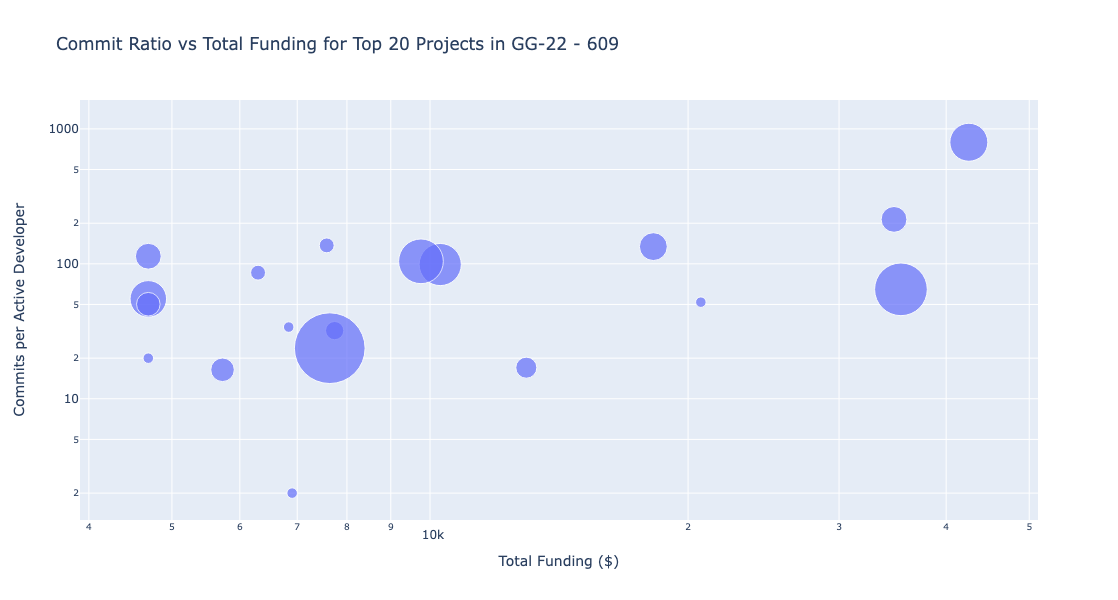

In [26]:
import plotly.express as px

# Assuming `results_df` is the dataframe containing the query results
results_df = results.to_dataframe()

# Calculate the ratio of commit_count_6_months to active_developer_count_6_months
results_df['commit_ratio'] = results_df['commit_count_6_months'] / results_df['active_developer_count_6_months']

# Create the scatter plot using Plotly with bubble size
fig = px.scatter(
    results_df,
    x='total_funding',
    y='commit_ratio',
    size='active_developer_count_6_months',  # Bubble size
    size_max=50,
    hover_data=['to_project_name'],
    labels={
        'total_funding': 'Total Funding ($)',
        'commit_ratio': 'Commits per Active Developer',
        'active_developer_count_6_months': 'Active Developers'
    },
    title='Commit Ratio vs Total Funding for Top 20 Projects in GG-22 - 609',
    log_x=True,  # Logarithmic X-axis
    log_y=True   # Logarithmic Y-axis
)

# Update layout for better visualization
fig.update_layout(
    xaxis_title='Total Funding ($)',
    yaxis_title='Commits per Active Developer',
    height=600,
    width=800
)

# Show the scatter plot
fig.show()

### Discover grantees with most similar coding metrics to another project

In [9]:
query = """
    WITH reference_metrics AS (
        SELECT 
            active_developer_count_6_months AS reference_active_developers,
            commit_count_6_months / active_developer_count_6_months AS reference_commit_per_developer,
            contributor_count_6_months / active_developer_count_6_months AS reference_contributor_per_developer
        FROM `oso_production.code_metrics_by_project_v1`
        WHERE project_name = 'opensource-observer'
    )
    SELECT 
        project_name,
        active_developer_count_6_months,
        commit_count_6_months / active_developer_count_6_months AS commit_per_developer,
        contributor_count_6_months / active_developer_count_6_months AS contributor_per_developer,
        SQRT(
            POWER((commit_count_6_months / active_developer_count_6_months - reference_commit_per_developer), 2) +
            POWER((contributor_count_6_months / active_developer_count_6_months - reference_contributor_per_developer), 2) +
            POWER((active_developer_count_6_months - reference_active_developers), 2)
        ) AS similarity_score
    FROM `oso_production.code_metrics_by_project_v1`, reference_metrics
    WHERE project_name != 'opensource-observer'
      and active_developer_count_6_months > 0
    ORDER BY similarity_score ASC
    LIMIT 10;
"""
results = client.query(query)
results.to_dataframe()

,project_name,active_developer_count_6_months,commit_per_developer,contributor_per_developer,similarity_score
0,decentraland,39.0,26.282051,1.564103,6.527619
1,fuellabs,49.0,18.306122,2.551020,6.797415
2,nodejs,51.0,21.647059,4.627451,7.049600
3,graph-protocol,38.0,24.052632,3.578947,7.294570
4,status-im,55.0,26.527273,1.763636,10.391057
5,polygon-hermez,38.0,32.578947,3.500000,11.463829
6,aztecprotocol,44.0,35.068182,2.863636,11.475806
7,servo,39.0,13.358974,1.589744,11.965279
8,layr-labs,35.0,31.200000,2.657143,12.541808
9,foundry,39.0,27.435897,12.512821,13.035938


### Find other funders of the top Gitcoin Grants recipients

In [12]:
query = """
    WITH top_projects AS (
        -- Select the top 50 projects funded by Gitcoin
        SELECT 
            to_project_name,
            SUM(amount) AS total_funding
        FROM 
            `oso_production.oss_funding_v0`
        WHERE 
            from_project_name = 'gitcoin'
        GROUP BY 
            to_project_name
        ORDER BY 
            total_funding DESC
        LIMIT 50
    )
    SELECT 
        o.to_project_name AS project,
        o.from_project_name AS funder,
        SUM(o.amount) AS funding_amount
    FROM 
        `oso_production.oss_funding_v0` o
    JOIN 
        top_projects t
    ON 
        o.to_project_name = t.to_project_name
    GROUP BY 
        o.from_project_name, o.to_project_name
    ORDER BY 
        project, funding_amount DESC;
"""
results = client.query(query)
results.to_dataframe()

,project,funder,funding_amount
0,0xparc,optimism,309081.000000
1,0xparc,gitcoin,167251.942560
2,4everland,gitcoin,132240.811258
3,beacon-chain,optimism,941367.365000
4,beacon-chain,gitcoin,266918.335561
...,...,...,...
103,walletconnect,opencollective,1.000000
104,wevm,optimism,930349.495000
105,wevm,gitcoin,179007.734368
106,zeropoolnetwork,gitcoin,325870.170831


### Funding Flows for top Gitcoin Grants Recipients

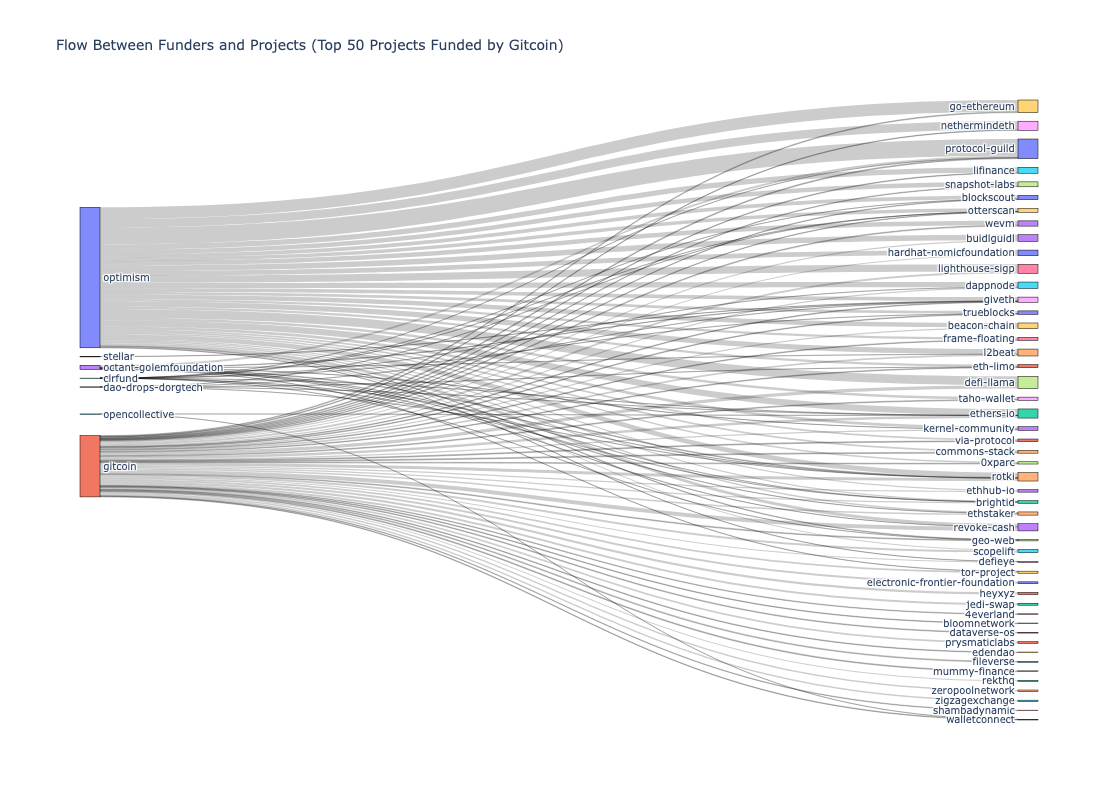

In [18]:
import plotly.graph_objects as go

# Assuming `results_df` is the dataframe containing the query results
results_df = results.to_dataframe()

# Prepare data for the chord diagram
funder_names = results_df['funder'].unique().tolist()
project_names = results_df['project'].unique().tolist()
all_names = funder_names + project_names

# Create a mapping for funders and projects to indices
name_to_index = {name: i for i, name in enumerate(all_names)}

# Map funders and projects to their indices
results_df['funder_index'] = results_df['funder'].map(name_to_index)
results_df['project_index'] = results_df['project'].map(name_to_index)

# Create the chord diagram using Plotly
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=all_names
    ),
    link=dict(
        source=results_df['funder_index'],
        target=results_df['project_index'],
        value=results_df['funding_amount'],
        hovertemplate='Funding Amount: %{value}<extra></extra>'
    )
))

# Update layout for better visualization
fig.update_layout(
    title_text="Flow Between Funders and Projects (Top 50 Projects Funded by Gitcoin)",
    font_size=10,
    height = 800
    
)

# Show the chord map visual
fig.show()
